In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [38]:
# Import the needed libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn import metrics   
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb 

In [39]:
df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [40]:
# Seperating what we use for training and prediction
X = df.drop(['Class'], axis=1)
Y = df['Class']
# Spliting so we have an accurate idea of model performance
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,y_test, test_size=.5, random_state = 42)

In [41]:
# Shape for NN
X_train.shape

(199364, 30)

In [42]:
# First model, let's see how this holds up.
model = Sequential()

model.add(keras.layers.Dense(128, activation='relu', input_shape=(30,)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(keras.layers.Dense(1, activation = "sigmoid"))

print('model defined :)')

model defined :)


In [43]:
# Saving the model
checkpoint = ModelCheckpoint('FraudDetectionModel.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)
# Stopping at a certain number of epochs to save time if model isn't learning
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

opt = keras.optimizers.Adam(lr=0.001)

# Now put it all together
model.compile(loss='binary_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [44]:
# First model let's train.
hist = model.fit(X_train, y_train,
        epochs=5,
        validation_data=(X_val, Y_val),
        callbacks = callbacks)

Epoch 1/5
6231/6231 [==============================] - 13s 2ms/step - loss: 0.0768 - accuracy: 0.9755 - val_loss: 0.0109 - val_accuracy: 0.9986

Epoch 00001: val_loss improved from inf to 0.01091, saving model to FraudDetectionModel.h5
Epoch 2/5
6231/6231 [==============================] - 12s 2ms/step - loss: 0.0142 - accuracy: 0.9982 - val_loss: 0.0113 - val_accuracy: 0.9986

Epoch 00002: val_loss did not improve from 0.01091
Epoch 3/5
6231/6231 [==============================] - 13s 2ms/step - loss: 0.0130 - accuracy: 0.9983 - val_loss: 0.7234 - val_accuracy: 0.9980

Epoch 00003: val_loss did not improve from 0.01091
Epoch 4/5
6231/6231 [==============================] - 12s 2ms/step - loss: 0.0137 - accuracy: 0.9982 - val_loss: 0.6719 - val_accuracy: 0.9981

Epoch 00004: val_loss did not improve from 0.01091

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/5
6231/6231 [==============================] - 12s 2ms/step - loss: 0.0134 - accuracy:

In [45]:
model.evaluate(X_test, Y_test)[1]

1336/1336 [==============================] - 1s 852us/step - loss: 0.0573 - accuracy: 0.9978


0.9977996945381165

In [46]:
# 99.72% Accuracy is amazing for the first go! Why did it stop learning after epoch 1? Maybe step count was too high.

In [47]:
# Let's try it with decreased steps

In [48]:
modelB = Sequential()

modelB.add(keras.layers.Dense(128, activation='relu', input_shape=(30,)))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.25))
modelB.add(keras.layers.Dense(128, activation='relu'))
modelB.add(BatchNormalization())
modelB.add(Dropout(0.25))
modelB.add(keras.layers.Dense(1, activation = "sigmoid"))

print('modelB defined :)')

checkpointB = ModelCheckpoint('FraudDetectionModelB.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystopB = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=100,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lrB = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacksB = [earlystopB,checkpointB,reduce_lrB]

optB = keras.optimizers.Adam(lr=0.001)

modelB.compile(loss='binary_crossentropy',
              optimizer = optB,
              metrics=['accuracy'])

modelB defined :)


In [49]:
histB = modelB.fit(X_train, y_train,
        epochs=10,
        validation_data=(X_val, Y_val),
        steps_per_epoch=50,
        callbacks = callbacksB)

Epoch 1/10
50/50 [==============================] - 3s 50ms/step - loss: 0.7269 - accuracy: 0.6198 - val_loss: 0.3561 - val_accuracy: 0.9985

Epoch 00001: val_loss improved from inf to 0.35613, saving model to FraudDetectionModelB.h5
Epoch 2/10
50/50 [==============================] - 2s 46ms/step - loss: 0.3975 - accuracy: 0.9107 - val_loss: 0.1764 - val_accuracy: 0.9986

Epoch 00002: val_loss improved from 0.35613 to 0.17639, saving model to FraudDetectionModelB.h5
Epoch 3/10
50/50 [==============================] - 2s 47ms/step - loss: 0.1960 - accuracy: 0.9840 - val_loss: 0.0860 - val_accuracy: 0.9986

Epoch 00003: val_loss improved from 0.17639 to 0.08601, saving model to FraudDetectionModelB.h5
Epoch 4/10
50/50 [==============================] - 2s 46ms/step - loss: 0.0908 - accuracy: 0.9957 - val_loss: 0.0464 - val_accuracy: 0.9986

Epoch 00004: val_loss improved from 0.08601 to 0.04642, saving model to FraudDetectionModelB.h5
Epoch 5/10
50/50 [==============================] - 

In [50]:
modelB.evaluate(X_test, Y_test)[1]

1336/1336 [==============================] - 1s 909us/step - loss: 0.0145 - accuracy: 0.9982


0.998197615146637

In [51]:
# Slightly better accuracy. May be due to the loss being able to increase steadily instead of sporadically
# Graphs should look decent now

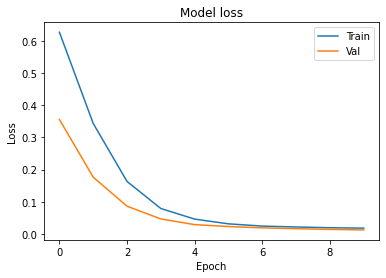

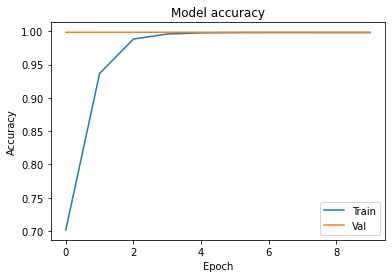

In [52]:
plt.plot(histB.history['loss'])
plt.plot(histB.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()
plt.plot(histB.history['accuracy'])
plt.plot(histB.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [53]:
modelC = Sequential()

modelC.add(keras.layers.Dense(128, activation='relu', input_shape=(30,)))
modelC.add(BatchNormalization())
modelC.add(Dropout(0.25))
modelC.add(keras.layers.Dense(1, activation = "sigmoid"))

print('modelC defined :)')

checkpointC = ModelCheckpoint('FraudDetectionModelC.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystopC = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=100,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lrC = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacksC = [earlystopC,checkpointC,reduce_lrC]

optC = keras.optimizers.Adam(lr=0.001)

modelC.compile(loss='binary_crossentropy',
              optimizer = optC,
              metrics=['accuracy'])

modelC defined :)


In [54]:
histC = modelC.fit(X_train, y_train,
        epochs=10,
        validation_data=(X_val, Y_val),
        steps_per_epoch=50,
        callbacks = callbacksC)

Epoch 1/10
50/50 [==============================] - 2s 37ms/step - loss: 0.6570 - accuracy: 0.6580 - val_loss: 0.4759 - val_accuracy: 0.9983

Epoch 00001: val_loss improved from inf to 0.47589, saving model to FraudDetectionModelC.h5
Epoch 2/10
50/50 [==============================] - 2s 34ms/step - loss: 0.3320 - accuracy: 0.9518 - val_loss: 0.2074 - val_accuracy: 0.9986

Epoch 00002: val_loss improved from 0.47589 to 0.20739, saving model to FraudDetectionModelC.h5
Epoch 3/10
50/50 [==============================] - 2s 33ms/step - loss: 0.1380 - accuracy: 0.9933 - val_loss: 0.1663 - val_accuracy: 0.9986

Epoch 00003: val_loss improved from 0.20739 to 0.16629, saving model to FraudDetectionModelC.h5
Epoch 4/10
50/50 [==============================] - 2s 33ms/step - loss: 0.0643 - accuracy: 0.9974 - val_loss: 0.1111 - val_accuracy: 0.9986

Epoch 00004: val_loss improved from 0.16629 to 0.11111, saving model to FraudDetectionModelC.h5
Epoch 5/10
50/50 [==============================] - 

In [55]:
modelC.evaluate(X_test, Y_test)[1]

1336/1336 [==============================] - 1s 781us/step - loss: 0.0174 - accuracy: 0.9982


0.998197615146637

In [56]:
# Same accuracy.. Lets try something a bit different, but may work.

In [57]:
# Single Perceptron!
modelD = Sequential()

modelD.add(keras.layers.Dense(1, activation = "sigmoid", input_shape=(30,)))

print('modelD defined :)')

checkpointD = ModelCheckpoint('FraudDetectionModelD.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystopD = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=100,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lrD = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacksD = [earlystopD,checkpointD,reduce_lrD]

optD = keras.optimizers.Adam(lr=0.001)

modelD.compile(loss='binary_crossentropy',
              optimizer = optD,
              metrics=['accuracy'])

modelD defined :)


In [58]:
histD = modelD.fit(X_train, y_train,
        epochs=10,
        validation_data=(X_val, Y_val),
        # This one wont need step changes
        #steps_per_epoch=50,
        callbacks = callbacksD)

Epoch 1/10
6231/6231 [==============================] - 7s 1ms/step - loss: 4493.9458 - accuracy: 0.7716 - val_loss: 0.8323 - val_accuracy: 0.9986

Epoch 00001: val_loss improved from inf to 0.83233, saving model to FraudDetectionModelD.h5
Epoch 2/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.7241 - accuracy: 0.9972 - val_loss: 2.2239 - val_accuracy: 0.9985

Epoch 00002: val_loss did not improve from 0.83233
Epoch 3/10
6231/6231 [==============================] - 6s 1ms/step - loss: 0.8937 - accuracy: 0.9971 - val_loss: 0.7591 - val_accuracy: 0.9985

Epoch 00003: val_loss improved from 0.83233 to 0.75909, saving model to FraudDetectionModelD.h5
Epoch 4/10
6231/6231 [==============================] - 7s 1ms/step - loss: 0.7972 - accuracy: 0.9966 - val_loss: 0.0615 - val_accuracy: 0.9975

Epoch 00004: val_loss improved from 0.75909 to 0.06145, saving model to FraudDetectionModelD.h5
Epoch 5/10
6231/6231 [==============================] - 6s 1ms/step - loss: 0.7817

In [59]:
modelD.evaluate(X_test, Y_test)[1]

1336/1336 [==============================] - 1s 772us/step - loss: 0.0811 - accuracy: 0.9985


0.9985018968582153

In [60]:
# That's crazy, how did a simple perceptron do better than a DNN. Make's me wonder if RandomForest of XGBoost can make this even better.
# Lets try RandomForest and XGB

In [61]:
# Won't be needing validation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

In [62]:
rf = RandomForestClassifier(n_estimators = 25)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [63]:
print("RandomForest acc: ", metrics.accuracy_score(y_test, y_pred)) 

RandomForest acc:  0.999602073897218


In [64]:
# Wow!! I knew that perceptron idea was going somewhere, lets try XGBoost.

In [65]:
XG = xgb.XGBClassifier() 
XG.fit(X_train, y_train)
y_pred = XG.predict(X_test) 

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:29:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [66]:
print('XGBoost acc: ', metrics.accuracy_score(y_test, y_pred))

XGBoost acc:  0.9996722961506501


In [68]:
# Looks like we have a winner! I could try hyper param tuning next using grid search or bayesian opt to make it even better, but as it stands a rounded accuracy of 99.96% is very good!
# This may take awhile but I'm going to do some cross validation to get an average accuracy across my data. Sometimes 99.96% Can be too good to be true as a general accuracy.

In [72]:
from sklearn.model_selection import cross_val_score
AvgAcc = print(cross_val_score(XG, X_test, y_test, cv=10, scoring='accuracy').mean())

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:33:16] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:33:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:33:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:33:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:34:02] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:34:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:34:26] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:34:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:34:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:35:01] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9995318543818472


In [74]:
# Okay if you can't see it cause of the hoopla,
# Our avg acc was '99.953%'

In [ ]:
# That was a lot higher than I expected. Little to no change!
# So to finalize it all, the best model was XGBoost with a generalized accuracy of 99.953% across 10 seperate folds.
# I'm very happy with the results especially when the generalized acc is above 99.95% That's crazy to me! 